# Comparative analysis

## Imports & Parameters

In [1]:
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from itertools import product
from functools import partial
from scipy.ndimage import uniform_filter

In [2]:
# Add local module to the path
src = os.path.abspath('../src')
if src not in sys.path:
    sys.path.append(src)

In [3]:
from metadata import City, CITIES, DATA_DIR
import classification as cls
import raster as rst
from landsat import Scene

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
RANDOM_SEED = 2018

In [6]:
def pretty(city_id):
    """Format city label."""
    name = city_id.title()
    name = name.replace('_', '-')
    return name

In [7]:
def write_raster(array, rasterio_profile, filename):
    """Write raster to disk."""
    profile = rasterio_profile.copy()
    profile.update(dtype=array.dtype.name, nodata=None, transform=None)
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(array, 1)
    return filename

In [8]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [9]:
# Plotting style
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rc('font', family='serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('text', usetex=True)

## Reference classification

The reference classification makes use of the reference polygons for training. Because reference polygons are used for both training and validation, polygons are randomly splitted between both datasets according to the `TEST_SIZE` parameter. In other words, half the polygons are used for training, and the others for validation. The procedure is performed `N` times and then the scores are averaged. Fixed random seeds are used to allow the reproducibility of the results (through the `RANDOM_SEED` and the `random_seeds` variables).

In [61]:
TEST_SIZE = 0.5
N = 20

# Set of fixed seeds for reproducibility of train_test_split function
random_seeds = np.arange(1, N+1, 1)

In [55]:
results = {}
progress = tqdm(total=len(CITIES) * N)

for city_name in CITIES:
    
    city = City(city_name)
    
    output_dir = os.path.join(city.output_dir, 'ref')
    os.makedirs(output_dir, exist_ok=True)

    scene = Scene(city.landsat_dir)
    shape = scene.red.shape
    mean_probabilities = np.zeros(shape=shape, dtype=np.float64)
    
    results[city_name] = []
    
    for n, seed in zip(range(N), random_seeds):
        
        training_dataset = np.zeros(shape=shape, dtype=np.uint8)
        testing_dataset = np.zeros(shape=shape, dtype=np.uint8)
        
        bu_train, bu_test = train_test_split(city.reference_builtup, test_size=TEST_SIZE, random_state=seed)
        so_train, so_test = train_test_split(city.reference_baresoil, test_size=TEST_SIZE, random_state=seed)
        lv_train, lv_test = train_test_split(city.reference_lowveg, test_size=TEST_SIZE, random_state=seed)
        hv_train, hv_test = train_test_split(city.reference_highveg, test_size=TEST_SIZE, random_state=seed)
        
        # Training dataset
        training_dataset = np.zeros(shape=shape, dtype=np.uint8)
        for polygons, value in zip([bu_train, so_train, lv_train, hv_train], [1, 2, 3, 4]):
            y = rst.rasterize(polygons, city.profile).astype(np.bool)
            training_dataset[y] = value
        
        # Testing dataset
        testing_dataset = np.zeros(shape=shape, dtype=np.uint8)
        for polygons, value in zip([bu_test, so_test, lv_test, hv_test], [1, 2, 3, 4]):
            y = rst.rasterize(polygons, city.profile).astype(np.bool)
            testing_dataset[y] = value
            
        # Classification
        probabilities = cls.classify(
            scene, training_dataset, oversampling=True, water=city.water, n_jobs=6, random_state=RANDOM_SEED, n_estimators=100)
        mean_probabilities = mean_probabilities + probabilities
        
        # Assessment
        results[city_name].append(cls.assess(probabilities, testing_dataset))
        
        progress.update(1)
        
    mean_probabilities = mean_probabilities / N
    write_raster(mean_probabilities, city.profile, os.path.join(output_dir, 'probabilities.tif'))

progress.close()

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

In [56]:
METRICS = ['f1_score', 'precision', 'recall', 'builtup_accuracy', 'baresoil_accuracy', 'lowveg_accuracy', 'highveg_accuracy']

scores_ref = pd.DataFrame(index=CITIES, columns=METRICS)

for city, metric in product(CITIES, METRICS):
    
    array = np.array([result[metric] for result in results[city]])
    scores_ref.at[(city, metric)] = array

Averaged and rounded scores for each case study:

In [57]:
rounder = partial(round, ndigits=2)
scores_ref_mean = scores_ref.applymap(np.mean).applymap(rounder)
scores_ref_std = scores_ref.applymap(np.std).applymap(rounder)

In [143]:
scores_ref_mean.to_csv(os.path.join(DATA_DIR, 'output', 'scores_ref_mean.csv'))
scores_ref_std.to_csv(os.path.join(DATA_DIR, 'output', 'scores_ref_std.csv'))
display(scores_ref_mean)
display(scores_ref_std)

,f1_score,precision,recall,builtup_accuracy,baresoil_accuracy,lowveg_accuracy,highveg_accuracy
antananarivo,0.92,0.97,0.87,0.87,0.96,1.00,1.00
chimoio,0.85,0.93,0.79,0.79,0.92,0.97,1.00
dakar,0.94,0.98,0.90,0.90,0.94,0.99,1.00
gao,0.84,0.84,0.86,0.86,0.91,0.98,0.99
johannesburg,0.96,0.98,0.94,0.94,0.92,0.94,0.98
kampala,0.98,0.99,0.96,0.96,0.98,0.99,1.00
katsina,0.94,0.99,0.90,0.90,0.98,0.96,0.99
nairobi,0.93,0.97,0.89,0.89,0.89,0.99,1.00
saint_louis,0.92,0.98,0.88,0.88,0.99,1.00,1.00
windhoek,0.93,0.96,0.90,0.90,0.94,0.99,1.00


,f1_score,precision,recall,builtup_accuracy,baresoil_accuracy,lowveg_accuracy,highveg_accuracy
antananarivo,0.02,0.02,0.05,0.05,0.03,0.00,0.00
chimoio,0.03,0.03,0.05,0.05,0.04,0.02,0.00
dakar,0.02,0.01,0.03,0.03,0.03,0.01,0.00
gao,0.09,0.16,0.06,0.06,0.12,0.02,0.01
johannesburg,0.01,0.01,0.01,0.01,0.04,0.03,0.01
kampala,0.01,0.01,0.02,0.02,0.02,0.01,0.00
katsina,0.03,0.01,0.06,0.06,0.02,0.03,0.02
nairobi,0.02,0.02,0.04,0.04,0.06,0.01,0.00
saint_louis,0.02,0.02,0.04,0.04,0.01,0.00,0.00
windhoek,0.02,0.02,0.04,0.04,0.04,0.01,0.00


## Using OSM buildings & non-built objects

In [71]:
BUILDINGS_MIN_COVERAGE = 0.2
METRICS = ['f1_score', 'precision', 'recall', 'builtup_accuracy', 'baresoil_accuracy', 'lowveg_accuracy', 'highveg_accuracy']

In [73]:
scores_osm_a = pd.DataFrame(index=CITIES, columns=METRICS)

progress = tqdm(total=len(CITIES))

for city_name in CITIES:
    
    city = City(city_name)
    
    scene = Scene(city.landsat_dir)
    
    training_dataset = np.zeros(shape=scene.red.shape, dtype=np.uint8)
    training_dataset[city.buildings_cover >= 0.2] = 1
    training_dataset[city.nonbuilt_raster > 0] = 2

    testing_dataset = city.reference
        
    probabilities = cls.classify(
        scene, training_dataset, oversampling=True, water=city.water, n_jobs=8, random_state=RANDOM_SEED, n_estimators=100)
        
    assessment = cls.assess(probabilities, testing_dataset)
    
    for metric in METRICS:
        scores_osm_a.at[(city_name, metric)] = round(assessment[metric], 2)
    
    # Save results to disk
    output_dir = os.path.join(city.output_dir, 'osm_a')
    os.makedirs(output_dir, exist_ok=True)
    write_raster(probabilities, city.profile, os.path.join(output_dir, 'probabilities.tif'))
    write_raster(training_dataset, city.profile, os.path.join(output_dir, 'training_dataset.tif'))
    with open(os.path.join(output_dir, 'assessment.json'), 'w') as f:
        f.write(json.dumps(assessment, indent=True, cls=NumpyEncoder))
    
    progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [141]:
scores_osm_a.to_csv(os.path.join(DATA_DIR, 'output', 'scores_osm_a.csv'))
scores_osm_a

,f1_score,precision,recall,builtup_accuracy,baresoil_accuracy,lowveg_accuracy,highveg_accuracy
antananarivo,0.78,0.99,0.65,0.65,1,1,1
chimoio,0.77,0.63,0.97,0.97,0.49,0.77,0.58
dakar,0.95,0.98,0.92,0.92,0.95,0.97,1
gao,0.81,0.96,0.69,0.69,0.99,1,0.99
johannesburg,0.6,0.98,0.43,0.43,0.94,1,1
kampala,0.98,1,0.97,0.97,0.99,1,1
katsina,0.2,0.84,0.11,0.11,0.95,0.96,1
nairobi,0.91,0.94,0.89,0.89,0.79,1,1
saint_louis,0.95,0.98,0.93,0.93,0.99,1,1
windhoek,0.68,0.98,0.52,0.52,0.98,1,1


## Using urban blocks & urban distance

In [75]:
BLOCKS_MAX_SIZE = 3.0  # in hectares
BUILDINGS_MIN_COVER = 0.2  # 20%
URBAN_DIST_THRESHOLD = 250  # in meters
METRICS = ['f1_score', 'precision', 'recall', 'builtup_accuracy', 'baresoil_accuracy', 'lowveg_accuracy', 'highveg_accuracy']

In [76]:
scores_osm_b = pd.DataFrame(index=CITIES, columns=METRICS)

progress = tqdm(total=len(CITIES))

for city_name in CITIES:
    
    city = City(city_name)
    scene = Scene(city.landsat_dir)
    mask = np.logical_or(scene.mask, city.water)
    
    training_dataset = np.zeros(shape=scene.red.shape, dtype=np.uint8)
    
    buildings = (city.buildings_cover >= BUILDINGS_MIN_COVER) & ~mask
    blocks = (city.blocks_raster <= BLOCKS_MAX_SIZE) & (city.blocks_raster > 0.1) & ~mask
    nonbuilt = (city.nonbuilt_raster > 0) & ~mask
    urban_distance = (city.urban_distance >= URBAN_DIST_THRESHOLD) & ~mask
    
    positive = np.logical_or(buildings, blocks)
    negative = np.logical_or(nonbuilt, urban_distance)
    confused = np.logical_and(positive, negative)
    positive[confused] = 0
    negative[confused] = 0

    n_positive = np.count_nonzero(positive)
    n_negative = np.count_nonzero(negative)
    
    if n_negative > 2 * n_positive:
        negative = rst.random_choice(negative, size=n_positive*2)
        n_negative = np.count_nonzero(negative)
    
    training_dataset[positive] = 1
    training_dataset[negative] = 2
            
    testing_dataset = city.reference
        
    probabilities = cls.classify(
        scene, training_dataset, oversampling=True, water=city.water, n_jobs=8, random_state=RANDOM_SEED, n_estimators=100)
    
    classes = np.zeros(shape=probabilities.shape, dtype=np.uint8)
    classes[probabilities >= 0.75] = 1
    classes[probabilities < 0.75] = 2
    classes[city.water] = 2
    classes[scene.mask] = 0
            
    assessment = cls.assess(probabilities, testing_dataset, threshold=0.75)
    
    for metric in METRICS:
        scores_osm_b.at[(city_name, metric)] = round(assessment[metric], 2)
    
    # Write results to disk
    output_dir = os.path.join(city.output_dir, 'osm_b')
    os.makedirs(output_dir, exist_ok=True)
    write_raster(probabilities, city.profile, os.path.join(output_dir, 'probabilities.tif'))
    write_raster(training_dataset, city.profile, os.path.join(output_dir, 'training_dataset.tif'))
    with open(os.path.join(output_dir, 'assessment.json'), 'w') as f:
        f.write(json.dumps(assessment, indent=True, cls=NumpyEncoder))
    
    progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [142]:
scores_osm_b.to_csv(os.path.join(DATA_DIR, 'output', 'scores_osm_b.csv'))
scores_osm_b

,f1_score,precision,recall,builtup_accuracy,baresoil_accuracy,lowveg_accuracy,highveg_accuracy
antananarivo,0.93,0.91,0.96,0.96,0.88,1,1
chimoio,0.92,0.9,0.95,0.95,0.85,0.96,1
dakar,0.96,0.94,0.98,0.98,0.79,0.94,0.99
gao,0.9,0.94,0.86,0.86,0.98,0.95,0.93
johannesburg,0.92,1,0.86,0.86,0.99,1,1
kampala,0.98,0.99,0.96,0.96,0.98,0.99,1
katsina,0.91,0.95,0.87,0.87,0.89,0.93,0.94
nairobi,0.94,0.97,0.92,0.92,0.89,0.99,1
saint_louis,0.94,0.92,0.96,0.96,0.98,0.98,1
windhoek,0.95,0.93,0.98,0.98,0.91,0.98,1


## Influence of the training sample size

In [10]:
count = pd.DataFrame(index=CITIES, columns=['positive', 'negative'])

for city_name in CITIES:
    
    city = City(city_name)
    with rasterio.open(os.path.join(city.output_dir, 'osm_b', 'training_dataset.tif')) as src:
        train = src.read(1)
    count.at[(city_name, 'positive')] = np.count_nonzero(train == 1)
    count.at[(city_name, 'negative')] = np.count_nonzero(train == 2)

In [11]:
count.to_csv(os.path.join(DATA_DIR, 'output', 'n_training_samples.csv'))
count.sort_values(by='positive')

,positive,negative
gao,9936,19872
saint_louis,11731,23462
chimoio,14018,28036
windhoek,19122,38244
antananarivo,19901,39802
katsina,20944,41888
nairobi,58710,117420
kampala,81274,162548
dakar,101072,20379
johannesburg,218688,256420


In [14]:
count.join(scores_osm_b)[['positive', 'f1_score']].sort_values(by='f1_score', ascending=False)

,positive,f1_score
kampala,81274,0.98
dakar,101072,0.96
windhoek,19122,0.95
nairobi,58710,0.94
saint_louis,11731,0.94
antananarivo,19901,0.93
chimoio,14018,0.92
johannesburg,218688,0.92
katsina,20944,0.91
gao,9936,0.90


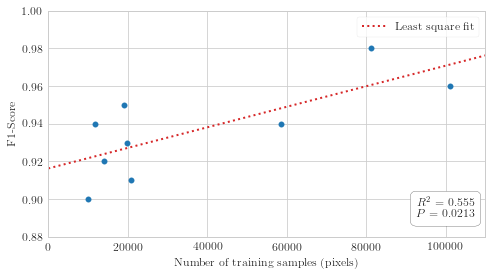

In [86]:
count_ = count.drop('johannesburg')
scores_osm_b_ = scores_osm_b.drop('johannesburg')

f, ax = plt.subplots(figsize=(7, 4))

x = count_.positive.astype(np.float64)
y = scores_osm_b_.f1_score

ax.scatter(x, y, label=None)
ax.set_ylim(0.88, 1.00)
ax.set_xlim(0, 110000)

slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot line of fit
x_values = np.array(ax.get_xlim())
y_values = slope * x_values + intercept
ax.plot(x_values, y_values, color='C3', linewidth=2, linestyle=':', label='Least square fit')
ax.annotate(
    f'$R^2$ = {round(r_value ** 2, 3)}\n$P$ = {round(p_value, 4)}',
    (100000, 0.89),
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
    ha='center'
)


ax.legend(frameon=True)
ax.set_xlabel('Number of training samples (pixels)')
ax.set_ylabel('F1-Score')

f.tight_layout()
f.savefig('../paper/figures/n_samples_fit.png')
f.savefig('../paper/figures/n_samples_fit.pdf');

In [176]:
cities = ('windhoek', 'antananarivo', 'katsina', 'nairobi', 'kampala', 'dakar', 'johannesburg')
n_samples = np.linspace(1000, 20000, 10).astype(int)
per_n_samples = pd.DataFrame(index=cities, columns=n_samples)

progress = tqdm(total=len(cities) * len(n_samples))

for city_name in cities:
    
    city = City(city_name)
    scene = Scene(city.landsat_dir)
    mask = np.logical_or(scene.mask, city.water)
    
    buildings = (city.buildings_cover >= BUILDINGS_MIN_COVER) & ~mask
    blocks = (city.blocks_raster <= BLOCKS_MAX_SIZE) & (city.blocks_raster > 0.1) & ~mask
    nonbuilt = (city.nonbuilt_raster > 0) & ~mask
    urban_distance = (city.urban_distance >= URBAN_DIST_THRESHOLD) & ~mask
    
    positive = np.logical_or(buildings, blocks)
    negative = np.logical_or(nonbuilt, urban_distance)
    confused = np.logical_and(positive, negative)
    positive[confused] = 0
    negative[confused] = 0
    
    for n in n_samples:
        
        training_dataset = np.zeros(shape=scene.red.shape, dtype=np.uint8)
        n_ = min(np.count_nonzero(positive), n)
        positive_ = rst.random_choice(positive, n_, random_seed=RANDOM_SEED)
        negative_ = rst.random_choice(negative, n_, random_seed=RANDOM_SEED)
        training_dataset[positive_] = 1
        training_dataset[negative_] = 2
        
        probabilities = cls.classify(
            scene, training_dataset, oversampling=True, water=city.water, n_jobs=8, random_state=RANDOM_SEED, n_estimators=10)

        assessment = cls.assess(probabilities, city.reference, threshold=0.75)
        per_n_samples.at[(city.name, n)] = round(assessment['f1_score'], 3)
        progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [236]:
per_n_samples.to_csv(os.path.join(DATA_DIR, 'output', 'per_n_samples.csv'))
per_n_samples

,1000,3111,5222,7333,9444,11555,13666,15777,17888,20000
windhoek,0.919,0.937,0.938,0.944,0.945,0.944,0.943,0.946,0.946,0.947
antananarivo,0.909,0.906,0.9,0.901,0.904,0.905,0.91,0.91,0.908,0.906
katsina,0.94,0.936,0.926,0.92,0.915,0.918,0.919,0.908,0.917,0.913
nairobi,0.922,0.93,0.933,0.933,0.937,0.934,0.939,0.936,0.937,0.941
kampala,0.952,0.968,0.976,0.973,0.974,0.974,0.974,0.973,0.972,0.974
dakar,0.931,0.933,0.94,0.938,0.94,0.943,0.943,0.944,0.944,0.944
johannesburg,0.865,0.878,0.878,0.883,0.884,0.885,0.887,0.886,0.89,0.892


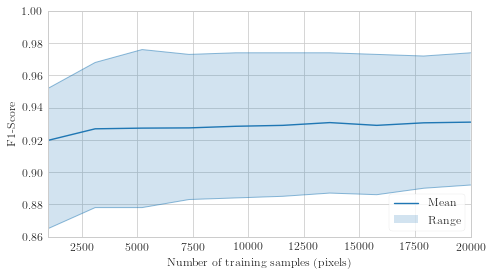

In [181]:
f, ax = plt.subplots(figsize=(7, 4))

x = n_samples
y_mean = per_n_samples.mean(axis=0)
y_min = per_n_samples.min(axis=0)
y_max = per_n_samples.max(axis=0)

ax.plot(y_mean, label='Mean')
ax.plot(y_min, color='C0', linewidth=1, alpha=0.5)
ax.plot(y_max, color='C0', linewidth=1, alpha=0.5)

ax.fill_between(x, y_min, y_max, facecolor='C0', alpha=0.2, label='Range')

ax.set_xlabel('Number of training samples (pixels)')
ax.set_ylabel('F1-Score')

ax.set_xlim(1000, 20000)
ax.set_ylim(0.86, 1.00)

ax.legend(frameon=True)

f.tight_layout()
f.savefig('../paper/figures/per_n_samples.png')
f.savefig('../paper/figures/per_n_samples.pdf');

### In Nairobi & Kampala

In [280]:
n_samples = np.linspace(1000, 50000, 20).astype(int)
n_samples_scores = pd.DataFrame(index=['kampala', 'nairobi'], columns=n_samples)
progress = tqdm(total=len(n_samples) * 2)

for city_name in ('kampala', 'nairobi'):

    city = City(city_name)
    scene = Scene(city.landsat_dir)
    mask = np.logical_or(scene.mask, city.water)

    buildings = (city.buildings_cover >= BUILDINGS_MIN_COVER) & ~mask
    blocks = (city.blocks_raster <= BLOCKS_MAX_SIZE) & (city.blocks_raster > 0.1) & ~mask
    nonbuilt = (city.nonbuilt_raster > 0) & ~mask
    urban_distance = (city.urban_distance >= URBAN_DIST_THRESHOLD) & ~mask

    positive = np.logical_or(buildings, blocks)
    negative = np.logical_or(nonbuilt, urban_distance)
    confused = np.logical_and(positive, negative)
    positive[confused] = 0
    negative[confused] = 0

    for n in n_samples:

        training_dataset = np.zeros(shape=scene.red.shape, dtype=np.uint8)
        n_ = min(np.count_nonzero(positive), n)
        positive_ = rst.random_choice(positive, n_, random_seed=RANDOM_SEED)
        negative_ = rst.random_choice(negative, n_, random_seed=RANDOM_SEED)
        training_dataset[positive_] = 1
        training_dataset[negative_] = 2

        probabilities = cls.classify(
            scene, training_dataset, oversampling=True, water=city.water, n_jobs=8, random_state=RANDOM_SEED, n_estimators=10)

        assessment = cls.assess(probabilities, city.reference, threshold=0.75)
        n_samples_scores.at[(city_name, n)] = round(assessment['f1_score'], 3)
        progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

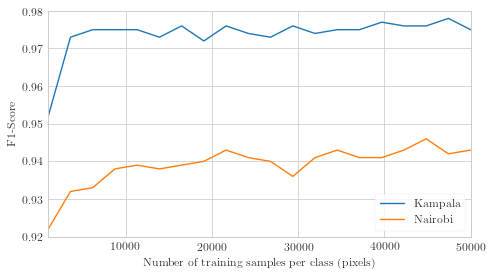

In [291]:
f, ax = plt.subplots(figsize=(7, 4))

ax.plot(n_samples_scores.loc['kampala'], label='Kampala')
ax.plot(n_samples_scores.loc['nairobi'], label='Nairobi')

ax.set_ylim(0.92, 0.98)
ax.set_xlim(1000, 50000)

ax.set_ylabel('F1-Score')
ax.set_xlabel('Number of training samples per class (pixels)')
ax.legend(frameon=True)

f.tight_layout()
f.savefig('../paper/figures/n_samples_nairobi_kampala.png')
f.savefig('../paper/figures/n_samples_nairobi_kampala.pdf');

## Influence of max. block size

In [121]:
BLOCKS_MAX_SIZES = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
per_block_size = pd.DataFrame(index=CITIES, columns=BLOCKS_MAX_SIZES)

progress = tqdm(total=len(CITIES) * len(BLOCKS_MAX_SIZES))

for city_name in CITIES:
    
    city = City(city_name)
    scene = Scene(city.landsat_dir)
    mask = np.logical_or(scene.mask, city.water)
    
    buildings = (city.buildings_cover >= BUILDINGS_MIN_COVER) & ~mask
    nonbuilt = (city.nonbuilt_raster > 0) & ~mask
    urban_distance = (city.urban_distance >= URBAN_DIST_THRESHOLD) & ~mask
    
    for max_size in BLOCKS_MAX_SIZES:
        
        training_dataset = np.zeros(shape=scene.red.shape, dtype=np.uint8)
        blocks = (city.blocks_raster <= max_size) & (city.blocks_raster > 0) & ~mask
        positive = np.logical_or(buildings, blocks)
        negative = np.logical_or(nonbuilt, urban_distance)
        confused = np.logical_and(positive, negative)
        positive[confused] = 0
        negative[confused] = 0

        n_positive = np.count_nonzero(positive)
        n_negative = np.count_nonzero(negative)

        if n_negative > 2 * n_positive:
            negative = rst.random_choice(negative, size=n_positive*2)
            n_negative = np.count_nonzero(negative)
        
        training_dataset[positive] = 1
        training_dataset[negative] = 2
        
        probabilities = cls.classify(
            scene, training_dataset, oversampling=True, water=city.water, n_jobs=8, random_state=RANDOM_SEED, n_estimators=10)

        assessment = cls.assess(probabilities, city.reference, threshold=0.75)
        per_block_size.at[(city.name, max_size)] = round(assessment['f1_score'], 3)
        progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=90), HTML(value='')))

In [144]:
per_block_size.to_csv(os.path.join(DATA_DIR, 'output', 'per_block_size.csv'))
per_block_size

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
antananarivo,0.926,0.927,0.927,0.916,0.92,0.917,0.92,0.916,0.916
chimoio,0.91,0.912,0.919,0.914,0.914,0.915,0.915,0.919,0.915
dakar,0.961,0.961,0.96,0.96,0.958,0.958,0.958,0.954,0.953
gao,0.899,0.803,0.901,0.902,0.801,0.9,0.905,0.899,0.807
johannesburg,0.823,0.846,0.877,0.9,0.914,0.924,0.93,0.936,0.939
kampala,0.975,0.973,0.972,0.973,0.973,0.972,0.971,0.971,0.974
katsina,0.906,0.917,0.903,0.908,0.906,0.9,0.911,0.903,0.899
nairobi,0.92,0.924,0.925,0.93,0.933,0.93,0.935,0.934,0.937
saint_louis,0.934,0.923,0.926,0.937,0.915,0.923,0.926,0.916,0.918
windhoek,0.945,0.943,0.946,0.947,0.951,0.952,0.952,0.953,0.954


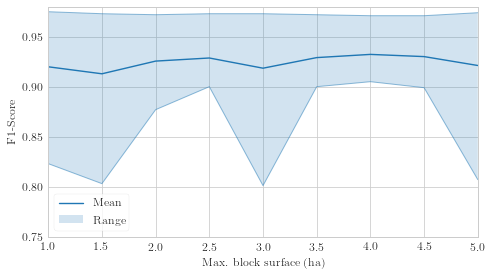

In [298]:
f, ax = plt.subplots(figsize=(7, 4))

x = np.linspace(1, 5, 9)
y_mean = per_block_size.mean(axis=0)
y_min = per_block_size.min(axis=0)
y_max = per_block_size.max(axis=0)

ax.plot(y_mean, label='Mean')
ax.plot(y_min, color='C0', linewidth=1, alpha=0.5)
ax.plot(y_max, color='C0', linewidth=1, alpha=0.5)

ax.fill_between(x, y_min, y_max, facecolor='C0', alpha=0.2, label='Range')

ax.set_xlim(1, 5)
ax.set_ylim(0.75, 0.98)
ax.set_xlabel('Max. block surface (ha)')
ax.set_ylabel('F1-Score')

ax.legend(frameon=True)

f.tight_layout()
f.savefig('../paper/figures/per_block_size.png')
f.savefig('../paper/figures/per_block_size.pdf');

## Influence of the probability threshold

In [248]:
thresholds = np.linspace(0, 1, 21)
per_threshold = pd.DataFrame(index=CITIES, columns=thresholds)

progress = tqdm(total=len(CITIES) * len(thresholds))

for city_name in CITIES:
    
    city = City(city_name)    
    testing_dataset = city.reference
    
    with rasterio.open(os.path.join(city.output_dir, 'osm_b', 'probabilities.tif')) as src:
        probabilities = src.read(1)
    
    for threshold in thresholds:
        
        assessment = cls.assess(probabilities, testing_dataset, threshold=threshold)
        per_threshold.at[(city.name, threshold)] = round(assessment['f1_score'], 2)
        progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=210), HTML(value='')))

In [249]:
per_threshold

,0.0,0.05,0.1,0.15000000000000002,0.2,0.25,0.30000000000000004,0.35000000000000003,0.4,0.45,...,0.55,0.6000000000000001,0.65,0.7000000000000001,0.75,0.8,0.8500000000000001,0.9,0.9500000000000001,1.0
antananarivo,0.43,0.68,0.74,0.79,0.8,0.83,0.84,0.85,0.86,0.87,...,0.89,0.91,0.92,0.93,0.93,0.93,0.93,0.92,0.89,0.72
chimoio,0.59,0.83,0.86,0.88,0.89,0.89,0.9,0.9,0.91,0.91,...,0.91,0.92,0.92,0.92,0.92,0.92,0.92,0.91,0.89,0.76
dakar,0.7,0.85,0.88,0.9,0.9,0.91,0.92,0.92,0.93,0.94,...,0.94,0.95,0.95,0.96,0.96,0.96,0.97,0.97,0.95,0.81
gao,0.44,0.79,0.8,0.81,0.82,0.82,0.82,0.82,0.82,0.82,...,0.91,0.91,0.91,0.9,0.9,0.89,0.88,0.87,0.85,0.78
johannesburg,0.86,0.96,0.97,0.98,0.98,0.98,0.98,0.98,0.97,0.97,...,0.96,0.95,0.95,0.93,0.92,0.91,0.87,0.83,0.7,0.32
kampala,0.69,0.88,0.92,0.94,0.95,0.96,0.97,0.97,0.97,0.98,...,0.98,0.98,0.98,0.98,0.98,0.97,0.97,0.96,0.91,0.73
katsina,0.8,0.85,0.87,0.88,0.89,0.9,0.9,0.9,0.91,0.91,...,0.91,0.91,0.91,0.91,0.91,0.9,0.89,0.88,0.85,0.74
nairobi,0.71,0.88,0.92,0.94,0.94,0.95,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,0.94,0.93,0.9,0.87,0.76,0.45
saint_louis,0.3,0.52,0.6,0.66,0.7,0.73,0.77,0.8,0.82,0.84,...,0.89,0.91,0.92,0.94,0.94,0.95,0.95,0.94,0.92,0.85
windhoek,0.58,0.82,0.86,0.89,0.9,0.91,0.92,0.93,0.93,0.94,...,0.94,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.93,0.84


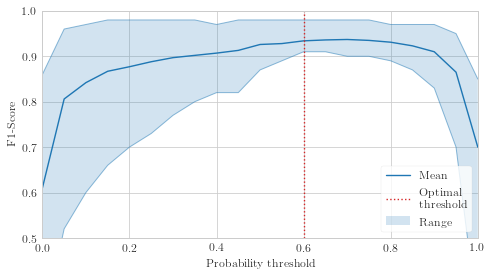

In [257]:
f, ax = plt.subplots(figsize=(7, 4))

x = thresholds
y_mean = per_threshold.mean(axis=0)
y_min = per_threshold.min(axis=0)
y_max = per_threshold.max(axis=0)

ax.plot(y_mean, label='Mean')
ax.plot(y_min, color='C0', linewidth=1, alpha=0.5)
ax.plot(y_max, color='C0', linewidth=1, alpha=0.5)

ax.fill_between(x, y_min, y_max, facecolor='C0', alpha=0.2, label='Range')

ax.set_xlim(0, 1)
ax.set_ylim(0.50, 1.00)
ax.set_xlabel('Probability threshold')
ax.set_ylabel('F1-Score')
ax.axvline(x=0.6, color='C3', linestyle=':', label='Optimal\nthreshold')

ax.legend(frameon=True)

f.tight_layout()
f.savefig('../paper/figures/per_prob_threshold.png')
f.savefig('../paper/figures/per_prob_threshold.pdf');

## Post-processing

In [268]:
kernel_sizes = [1, 3, 5, 7, 9]
postprocessing_scores = pd.DataFrame(index=CITIES, columns=kernel_sizes)
progress = tqdm(total=len(CITIES) * len(kernel_sizes))

for city_name in CITIES:
    
    city = City(city_name)
    
    with rasterio.open(os.path.join(city.output_dir, 'osm_b', 'probabilities.tif')) as src:
        probabilities = src.read(1)
    
    for size in kernel_sizes:
        
        probabilities_ = uniform_filter(probabilities, size=size)
        assessment = cls.assess(probabilities_, city.reference, threshold=0.6)
        postprocessing_scores.at[(city_name, size)] = round(assessment['f1_score'], 2)
        progress.update(1)

progress.close()

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

In [304]:
postprocessing_scores

,1,3,5,7,9
antananarivo,0.91,0.92,0.93,0.94,0.94
chimoio,0.92,0.94,0.95,0.96,0.96
dakar,0.95,0.96,0.96,0.96,0.96
gao,0.91,0.91,0.9,0.9,0.89
johannesburg,0.96,0.98,0.98,0.98,0.98
kampala,0.98,0.98,0.98,0.98,0.97
katsina,0.91,0.91,0.91,0.9,0.89
nairobi,0.95,0.97,0.96,0.96,0.95
saint_louis,0.9,0.95,0.96,0.96,0.95
windhoek,0.95,0.96,0.96,0.96,0.95


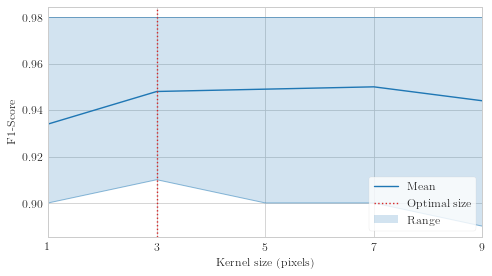

In [303]:
f, ax = plt.subplots(figsize=(7, 4))

x = kernel_sizes
y_mean = postprocessing_scores.mean(axis=0)
y_min = postprocessing_scores.min(axis=0)
y_max = postprocessing_scores.max(axis=0)

ax.plot(y_mean, label='Mean')
ax.plot(y_min, color='C0', linewidth=1, alpha=0.5)
ax.plot(y_max, color='C0', linewidth=1, alpha=0.5)

ax.fill_between(x, y_min, y_max, facecolor='C0', alpha=0.2, label='Range')

ax.set_xlim(1, 9)
ax.set_xlabel('Kernel size (pixels)')
ax.set_ylabel('F1-Score')
ax.set_xticks(kernel_sizes)
ax.axvline(x=3, color='C3', linestyle=':', label='Optimal size')
ax.legend(frameon=True, loc='lower right')

f.tight_layout()
f.savefig('../paper/figures/postprocessing_scores.png')
f.savefig('../paper/figures/postprocessing_scores.pdf');

In [306]:
# Write post-processed map to disk
for city_name in CITIES:
    
    city = City(city_name)
    
    for scheme in ('osm_a', 'osm_b', 'ref'):
    
        with rasterio.open(os.path.join(city.output_dir, scheme, 'probabilities.tif')) as src:
            probabilities = src.read(1)

        probabilities = uniform_filter(probabilities, size=3)
        bu_map = probabilities >= 0.75
        bu_map = bu_map.astype(np.uint8)

        output_f = os.path.join(city.output_dir, scheme, 'map.tif')
        write_raster(bu_map, city.profile, output_f)

## Summary

In [17]:
from itertools import product

In [15]:
scores_ref = pd.read_csv(os.path.join(DATA_DIR, 'output', 'scores_ref_mean.csv'), index_col=0)
scores_osm_a = pd.read_csv(os.path.join(DATA_DIR, 'output', 'scores_osm_a.csv'), index_col=0)
scores_osm_b = pd.read_csv(os.path.join(DATA_DIR, 'output', 'scores_osm_b.csv'), index_col=0)

In [46]:
cls_labels = ['osm_a', 'osm_b', 'ref']
metrics = ['f1_score', 'precision', 'recall']
columns = [cls + '_' + metric for cls, metric in product(cls_labels, metrics)]
scores = pd.DataFrame(index=CITIES, columns=columns)

In [47]:
for cls_scores, cls_label in zip([scores_osm_a, scores_osm_b, scores_ref], cls_labels):
    
    for city, metric in product(CITIES, metrics):
        
        col = cls_label + '_' + metric
        scores.at[(city, col)] = cls_scores.at[(city, metric)]

In [50]:
scores.loc['mean'] = scores.mean().round(2)
scores.loc['std'] = scores.std().round(2)

In [51]:
scores

,osm_a_f1_score,osm_a_precision,osm_a_recall,osm_b_f1_score,osm_b_precision,osm_b_recall,ref_f1_score,ref_precision,ref_recall
antananarivo,0.78,0.99,0.65,0.93,0.91,0.96,0.92,0.97,0.87
chimoio,0.77,0.63,0.97,0.92,0.9,0.95,0.85,0.93,0.79
dakar,0.95,0.98,0.92,0.96,0.94,0.98,0.94,0.98,0.9
gao,0.81,0.96,0.69,0.9,0.94,0.86,0.84,0.84,0.86
johannesburg,0.6,0.98,0.43,0.92,1,0.86,0.96,0.98,0.94
kampala,0.98,1,0.97,0.98,0.99,0.96,0.98,0.99,0.96
katsina,0.2,0.84,0.11,0.91,0.95,0.87,0.94,0.99,0.9
nairobi,0.91,0.94,0.89,0.94,0.97,0.92,0.93,0.97,0.89
saint_louis,0.95,0.98,0.93,0.94,0.92,0.96,0.92,0.98,0.88
windhoek,0.68,0.98,0.52,0.95,0.93,0.98,0.93,0.96,0.9
